In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np 
from matplotlib import pyplot as plt
import os 
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report

from scipy.optimize import minimize
from scipy import special as sc
from scipy.stats import pearsonr
from scipy.misc import derivative
from tensorflow.keras.utils import to_categorical


In [2]:
# Implementation of Negative Log likelihood for XPFS negative binomial fitting  

def nll(beta, k, kbar):
    M = 1/(beta**2)
    return -(1/len(k))*np.sum(sc.gammaln(M+k) - sc.gammaln(M) - k*np.log(kbar + M) + M*np.log((M)/(kbar + M)))

In [3]:
def calculate_contrast(photon_map):
    
    data = np.reshape(photon_map, (len(photon_map), -1))
    kbar = np.repeat(np.mean(data, axis=1),900) # Set kbar per pixel the estimated value from a given frame         
    k = np.reshape(data, -1)
    result = minimize(nll,0.5,args=(k,kbar),bounds=((0.001,2),))
    estimated_contrast = result.x
    
    # Calculate error bar using asymptotic distribution results for the MLE 
    dbeta = derivative(nll, x0=estimated_contrast,  n=2,  dx=1e-6,  args=(k,kbar))
    error_bar = 1.96/np.sqrt(dbeta*len(k))
    
    return estimated_contrast, error_bar

### Load and visualize simulated ADU photon maps

Please refer to: https://www.nature.com/articles/s41598-021-98774-3 for details on the implementation of the simulator. 

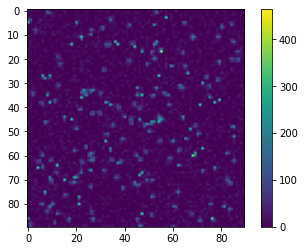

In [6]:
contrast_dir = '../data/contrast_0.8' # Can change to contrast_0.7 for data with a contrast = 0.7, photon energy 340 ADU, background sigma = 12
X_ADU_test = np.load(os.path.join(contrast_dir, 'detector_input.npy'))

# Visualize input data
plt.imshow(X_ADU_test[0])
plt.colorbar()

### Run CNN Model

Note, the results might be slightly different relative to the main text since only 1000 frames are used. This number was chosen to comply with the Github file size requirement. 

In [7]:
# Normalization parameters for data 
mean = 10.730222783711339
std = 28.770917957631106
X_ADU_test = (X_ADU_test-mean)/std

# Trained U-net model for kbar [0.025, 0.25] and contrasts [0.7,1.0]
model = model = tf.keras.models.load_model('../models/cnn_xpfs.h5')

# Make a prediction on 1000 frames 
photon_map = np.argmax(model.predict(X_ADU_test), axis=-1) 

# Calculate resulting contrast and error bars from photonized map
contrast, error_bar = calculate_contrast(photon_map)  
print("Contrast: ", contrast, '+-', error_bar)

2021-11-18 19:27:27.656722: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-18 19:27:27.657056: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-18 19:27:27.892156: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Contrast:  [0.80648677] +- 0.016891387101442716


### Compute ML metrics (F1, Precision, Recall per class)

Note, only 5 classes {0, 1, 2, 3, 4} are used since there is very little data corresponding to high photon events. 

In [8]:
cnn_photon_map = np.clip(np.argmax(model.predict(X_ADU_test), axis=-1),0,4)
ground_truth_photon_map = np.clip(np.load(os.path.join(contrast_dir, 'ground_truth.npy')),0,4)
droplet_photon_map = np.clip(np.load(os.path.join(contrast_dir, 'droplet_prediction.npy')),0,4)

print("ML metrics for Droplet")
print(classification_report(np.reshape(ground_truth_photon_map,-1),np.reshape(droplet_photon_map,-1)))
print("-----------------------------------------------------------------------------------------------")

print("ML metrics for CNN")
print(classification_report(np.reshape(ground_truth_photon_map,-1),np.reshape(cnn_photon_map,-1)))
print("-----------------------------------------------------------------------------------------------")


ML metrics for Droplet
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    792823
           1       0.97      0.96      0.96     94266
           2       0.90      0.90      0.90     11300
           3       0.82      0.83      0.82      1422
           4       0.83      0.81      0.82       189

    accuracy                           0.99    900000
   macro avg       0.90      0.90      0.90    900000
weighted avg       0.99      0.99      0.99    900000

-----------------------------------------------------------------------------------------------
ML metrics for CNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    792823
           1       0.97      0.97      0.97     94266
           2       0.91      0.93      0.92     11300
           3       0.84      0.87      0.85      1422
           4       0.85      0.77      0.81       189

    accuracy                           0.99    

### Visualize Predictions from CNN, Droplet and Ground Truth

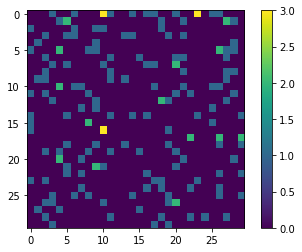

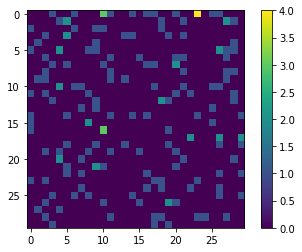

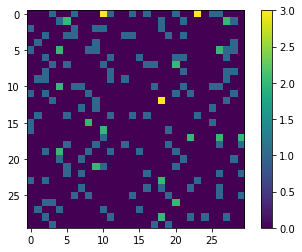

In [9]:
example_id = 47 

plt.imshow(cnn_photon_map[example_id])
plt.colorbar()
plt.show()

plt.imshow(ground_truth_photon_map[example_id])
plt.colorbar()
plt.show()

plt.imshow(droplet_photon_map[example_id])
plt.colorbar()
plt.show()